In [1]:
import os
import sys
import time
import copy
import torch 
import random
import torchvision
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader, random_split

## Get pretrained model

In [2]:
os.chdir('C:/Users/Siryu_sci/EffNetV2')
from EffNetV2 import get_efficientnet_v2

In [3]:
model = get_efficientnet_v2("efficientnet_v2_s", pretrained = True, \
                            nclass = 12, dropout=0.1, stochastic_depth=0.2)

In [4]:
print(model)

EfficientNetV2(
  (stem): ConvBNAct(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
  )
  (blocks): Sequential(
    (0): MBConv(
      (block): Sequential(
        (fused): ConvBNAct(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
        )
      )
      (stochastic_path): StochasticDepth()
    )
    (1): MBConv(
      (block): Sequential(
        (fused): ConvBNAct(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
        )
      )
      (stochastic_path): StochasticDepth()
    )
    (2): MBConv(
      (block): Sequential(
  

## The dataset and the dataloader

In [6]:
# Set hyperparams
batch_size  = 64
random_seed = 555
random.seed(random_seed)
torch.manual_seed(random_seed)

# load data, set transforms
data_path = 'C:/Users/Siryu_sci/EffNetV2/dataset/trashcan/garbage_classification/'
garbage_dset = ImageFolder(data_path, transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                        std = [0.229, 0.224, 0.225])
]))

print(len(garbage_dset))
# set train : valid : test = 85 : 10 : 5
train_size = int(0.85 * len(garbage_dset))
valid_size = int(0.1 * len(garbage_dset))
test_size = len(garbage_dset) - train_size - valid_size
train_data, val_data, test_data = random_split(garbage_dset, [train_size, valid_size, test_size])

datasets = {}
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(train_data,
                                            batch_size=batch_size, shuffle=True,
                                            num_workers=4)
dataloaders['valid'] = torch.utils.data.DataLoader(val_data,
                                            batch_size=batch_size, shuffle=False,
                                            num_workers=4)
dataloaders['test']  = torch.utils.data.DataLoader(test_data,
                                            batch_size=batch_size, shuffle=False,
                                            num_workers=4)
for i in range(2):
    images, labels = next(iter(dataloaders['train']))
    print(images.shape)
    print(labels)

15515
torch.Size([64, 3, 224, 224])
tensor([ 8, 10,  4,  1,  9,  4, 11,  7,  3,  4,  4,  4,  4,  4,  8,  4,  6,  8,
         8,  4,  2,  0,  4,  3, 11,  4,  0, 10,  9,  4,  4,  0, 10,  8,  4,  9,
         3,  4,  4,  3,  4,  4,  7,  0,  8,  4,  5,  7,  4,  3,  4,  4,  9,  0,
         9,  1,  9,  7,  4,  1,  4,  9,  6, 10])
torch.Size([64, 3, 224, 224])
tensor([ 9,  9,  5,  7,  5,  4, 10,  9,  6,  4,  6,  9,  9,  8,  4, 11,  6, 10,
         2, 10,  9,  3,  1,  3,  8,  6,  7,  4,  7,  6,  6,  4,  8,  4,  9,  8,
        11,  4,  9,  6,  8,  1,  9,  4,  4,  4,  9,  4,  0,  4,  3,  6,  3,  6,
         9,  4,  5,  4,  4,  7,  2,  4,  5,  1])


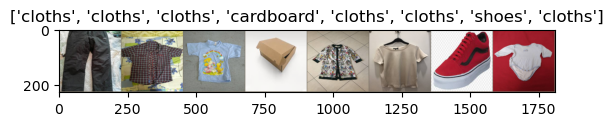

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

num_show_img = 8

class_names = {
    "0": "battery",    
    "1": "biological", 
    "2": "glass, brown",  
    "3": "cardboard",  
    "4": "cloths",   
    "5": "glass, green",   
    "6": "metal",
    "7": "paper",
    "8": "plastic",
    "9": "shoes",
    "10": "general waste",
    "11": "glass, white"   
}

# train check
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:num_show_img]) 
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

## Train the model

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    print("Current learning rate : ", optimizer.param_groups[0]['lr'])
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'RecycleModel.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), 
                         lr = 0.05,
                         momentum=0.9,
                         weight_decay=1e-4)

lmbda = lambda epoch: 0.9
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

In [12]:
for n, p in model.named_parameters():
    if 'head' not in n:
        p.requires_grad = False

In [15]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = \
    train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Current learning rate :  0.05
Epoch 0/2
----------
train Loss: 0.05 Acc: 98.7
valid Loss: 0.21 Acc: 94.6
==> best model saved - 0 / 94.6
Epoch 1/2
----------
train Loss: 0.05 Acc: 98.6
valid Loss: 0.19 Acc: 94.8
==> best model saved - 1 / 94.8
Epoch 2/2
----------
train Loss: 0.04 Acc: 98.9
valid Loss: 0.20 Acc: 94.5
Training complete in 1m 33s
Best valid Acc: 1 - 94.8
model saved


test done : loss/acc : 0.15 / 94.5


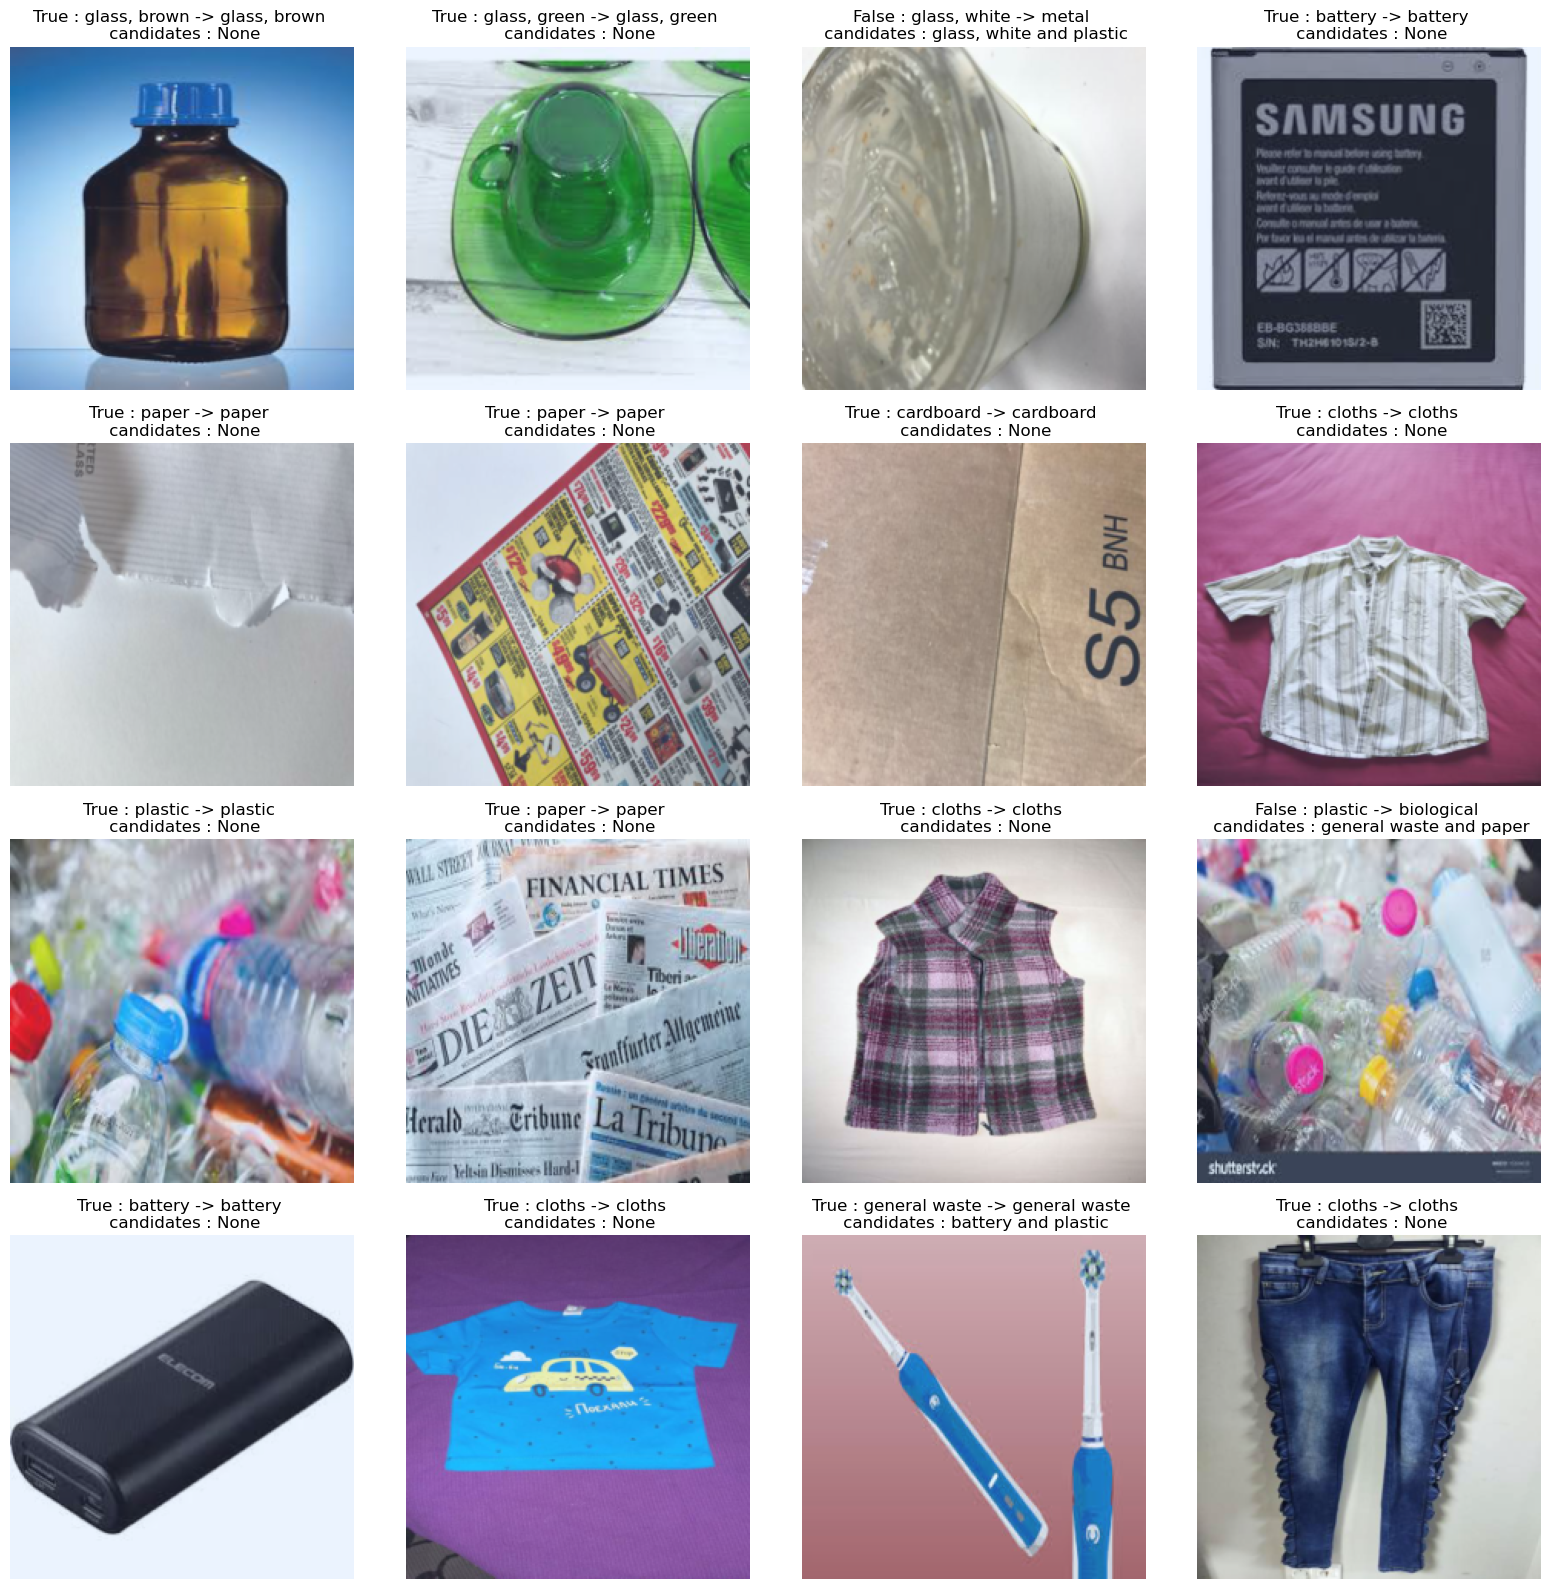

In [41]:
def test_and_visualize_model(model, phase = 'test', num_images=4):
    # phase = 'train', 'valid', 'test'
    
    was_training = model.training
    model.eval()
    # plot template
    cols = int(np.ceil(np.sqrt(num_images)))  # Calculate the number of columns for the grid
    rows = int(np.ceil(num_images / cols))    # Calculate the number of rows for the grid
    fig, axes = plt.subplots(rows, cols, figsize=(num_images, num_images))
    
    running_loss, running_corrects, num_cnt = 0.0, 0, 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)  # batch의 평균 loss 출력

            running_loss    += loss.item() * inputs.size(0)
            running_corrects+= torch.sum(preds == labels.data)
            num_cnt += inputs.size(0)  # batch size

    #         if i == 2: break

        test_loss = running_loss / num_cnt
        test_acc  = running_corrects.double() / num_cnt       
        print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))

    # plot examples
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.topk(outputs, k=3, dim=1)        
            set_num_to_print = 2
            if i==set_num_to_print:
                for j in range(num_images):
                    row = j // cols
                    col = j % cols
                    ax = axes[row, col]
                    ax.axis('off')
                    #print(inputs.cpu().data[j].permute(1, 2, 0))
                    img_np = inputs.cpu().data[j].permute(1, 2, 0).numpy()
                    img_np = img_np/np.amax(img_np)
                    img_np = img_np / 2 + 0.5
                    ax.imshow(img_np)
                    ax.set_title('%s : %s -> %s \n candidates : %s'%(
                        'True' if class_names[str(labels[j].cpu().numpy())]==class_names[str(preds[j][0].cpu().numpy())] else 'False',
                        class_names[str(labels[j].cpu().numpy())], class_names[str(preds[j][0].cpu().numpy())],
                class_names[str(preds[j][1].cpu().numpy())]+' and '+class_names[str(preds[j][2].cpu().numpy())]\
                    if (outputs[j][preds[j][0]]/outputs[j][preds[j][1]]<2) else "None" ))
                    #imshow(inputs.cpu().data[j])          
            if i == set_num_to_print : break


    model.train(mode=was_training);  # 다시 train모드로
    plt.tight_layout()
    plt.show()
    
# TEST!
test_and_visualize_model(model, phase = 'test', num_images=16)